In [1]:
from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set_style('darkgrid')

import plotly.offline as pyoff
import plotly.graph_objs as go

pyoff.init_notebook_mode()

1. Preparing data

In [2]:
data = pd.read_csv('main_training_data.csv')

print('Number of features: %s' %data.shape[1])
print('Number of examples: %s' %data.shape[0])

Number of features: 16
Number of examples: 48895


In [3]:
data.shape

(48895, 16)

In [4]:
data.head(10)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
6  5121                                   BlissArtsSpace!     7356   
7  5178                  Large Furnished Room Near B'way      8967   
8  5203                Cozy Clean Guest Room - Family Apt     7490   
9  5238                Cute & Cozy Lower East Side 1 bdrm     7549   

     host_name neighbourhood_group       neighbourhood  latitude  longitude  \
0         John            Brooklyn          Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan             Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan              Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn        Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan         East Harlem  40.79851  -73.94399   
5        Chris           Manhattan         Murray Hill  40.74767  -73.97500   
6        Garon            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
7     Shunichi           Manhattan      Hell's Kitchen  40.76489  -73.98493   
8    MaryEllen           Manhattan     Upper West Side  40.80178  -73.96723   
9          Ben           Manhattan           Chinatown  40.71344  -73.99037   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   
5  Entire home/apt    200               3                 74  2019-06-22   
6     Private room     60              45                 49  2017-10-05   
7     Private room     79               2                430  2019-06-24   
8     Private room     79               2                118  2017-07-21   
9  Entire home/apt    150               1                160  2019-06-09   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0  
5               0.59                               1               129  
6               0.40                               1                 0  
7               3.47                               1               220  
8               0.99                               1                 0  
9               1.33                               4               188

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [6]:
data['last_review'] = pd.to_datetime(data['last_review'])

In [7]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

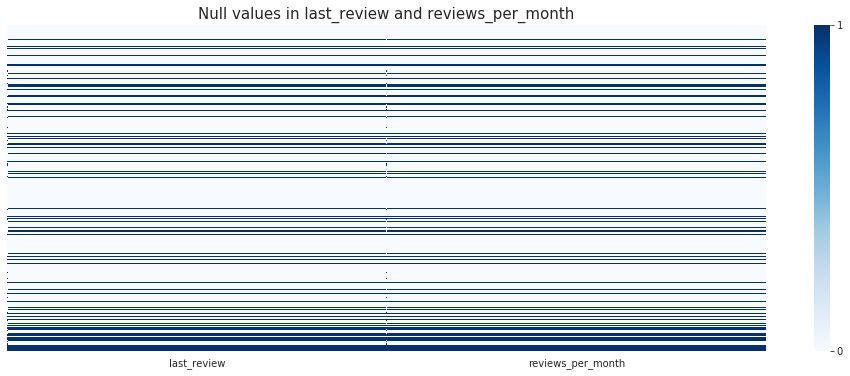

In [8]:
fig, ax = plt.subplots(figsize=(17,6))
plt.title('Null values in last_review and reviews_per_month', fontsize=15)
sns.heatmap(data[['last_review','reviews_per_month' ]].isnull(), cmap="Blues", yticklabels=False, ax=ax, cbar_kws={'ticks': [0, 1]})

## Filling empty values/

In [9]:
data["last_review"].fillna(data["last_review"].min(), inplace = True)

In [10]:
data["reviews_per_month"].fillna(0, inplace = True)

In [11]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

# Calculating RFM Scoring

### 1) Calculate Recency

In [12]:
df_user = pd.DataFrame(data['id'].unique())
df_user.columns = ['id']

In [13]:
df_user_recency = data.groupby('id').last_review.max().reset_index()
df_user_recency.columns = ["id", "Recency"]
df_user_recency.head()

id    Recency
0  2539 2018-10-19
1  2595 2019-05-21
2  3647 2011-03-28
3  3831 2019-07-05
4  5022 2018-11-19

In [14]:
df_user['Recency'] = (df_user_recency['Recency'].max() - df_user_recency['Recency']).dt.days
df_user.head()

id  Recency
0  2539      262
1  2595       48
2  3647     3024
3  3831        3
4  5022      231

In [15]:
plot_data = [
    go.Histogram(
        x=df_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

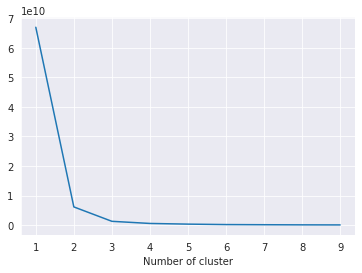

In [16]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


In [17]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)
print(df_user.head())

df_user.groupby('RecencyCluster')['Recency'].describe()

     id  Recency  RecencyCluster
0  2539      262               3
1  2595       48               3
2  3831        3               3
3  5022      231               3
4  5099       16               3


count         mean         std     min     25%     50%  \
RecencyCluster                                                             
0               10118.0  3019.954438   53.232521  2113.0  3024.0  3024.0   
1                4723.0  1202.984967  228.107533   866.0  1028.0  1151.0   
2                6336.0   528.595328  160.615557   293.0   374.0   550.0   
3               27718.0    56.536727   72.472731     0.0    10.0    23.0   

                   75%     max  
RecencyCluster                  
0               3024.0  3024.0  
1               1353.0  2109.0  
2                668.0   865.0  
3                 64.0   292.0

### 2) Calculate Frequency

In [18]:
df_user_freq = data.groupby('id').reviews_per_month.sum().reset_index()
df_user_freq.columns = ["id", "Frequency"]
df_user_freq.head()

df_user = pd.merge(df_user, df_user_freq, on='id')
df_user.head()

id  Recency  RecencyCluster  Frequency
0  2539      262               3       0.21
1  2595       48               3       0.38
2  3831        3               3       4.64
3  5022      231               3       0.10
4  5099       16               3       0.59

In [19]:
plot_data = [
    go.Histogram(
        x=df_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [20]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])
print(df_user.head())
#order the frequency cluster

df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

     id  Recency  RecencyCluster  Frequency  FrequencyCluster
0  2539      262               3       0.21                 0
1  2595       48               3       0.38                 0
2  3831        3               3       4.64                 1
3  5022      231               3       0.10                 0
4  5099       16               3       0.59                 0


count      mean       std   min   25%    50%   75%    max
FrequencyCluster                                                             
0                 31707.0  0.209316  0.254221  0.00  0.00  0.100  0.34   0.94
1                 10373.0  1.677148  0.523994  0.95  1.19  1.630  2.09   2.71
2                  5769.0  3.748930  0.750290  2.72  3.09  3.610  4.29   5.54
3                  1046.0  7.340937  2.546014  5.55  6.00  6.675  7.87  58.50

## 3) Calculate Monetary Value

In [21]:
data["Revenue"] = (data["reviews_per_month"]*30) * data["price"]
df_user_revenue = data.groupby('id').Revenue.sum().reset_index()
df_user_revenue.columns = ["id", "Revenue"]
df_user_revenue.head()

df_user = pd.merge(df_user, df_user_revenue, on='id')
df_user.head()

id  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue
0  2539      262               3       0.21                 0    938.7
1  2595       48               3       0.38                 0   2565.0
2  5022      231               3       0.10                 0    240.0
3  5099       16               3       0.59                 0   3540.0
4  5295       16               3       0.43                 0   1741.5

In [22]:
plot_data = [
    go.Histogram(
        x=df_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [23]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])
print(df_user.head())
#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'Revenue',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['Revenue'].describe()

     id  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0  2539      262               3       0.21                 0    938.7   
1  2595       48               3       0.38                 0   2565.0   
2  5022      231               3       0.10                 0    240.0   
3  5099       16               3       0.59                 0   3540.0   
4  5295       16               3       0.43                 0   1741.5   

   RevenueCluster  
0               0  
1               0  
2               0  
3               0  
4               0  


count          mean           std        min        25%  \
RevenueCluster                                                              
0               41166.0  1.711404e+03   2193.395015        0.0       36.0   
1                7051.0  1.538541e+04   5953.777326     8553.6    10745.4   
2                 677.0  5.260759e+04  25538.641054    34036.2    38176.5   
3                   1.0  1.383750e+06           NaN  1383750.0  1383750.0   

                      50%        75%        max  
RevenueCluster                                   
0                   690.0     2677.5     8550.0  
1                 13635.0    18447.0    33981.9  
2                 44304.0    57499.2   391092.0  
3               1383750.0  1383750.0  1383750.0

## OVERALL SCORING

In [24]:
#calculate overall score and use mean() to see details
df_user['OverallScore RFM'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
print(df_user.head())
df_user.groupby('OverallScore RFM')['Recency','Frequency','Revenue'].mean()

     id  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0  2539      262               3       0.21                 0    938.7   
1  2595       48               3       0.38                 0   2565.0   
2  5022      231               3       0.10                 0    240.0   
3  5099       16               3       0.59                 0   3540.0   
4  5295       16               3       0.43                 0   1741.5   

   RevenueCluster  OverallScore RFM  
0               0                 3  
1               0                 3  
2               0                 3  
3               0                 3  
4               0                 3  


Recency  Frequency       Revenue
OverallScore RFM                                      
0                 3019.954438   0.000395  1.779749e+00
1                 1203.682937   0.098823  4.234160e+02
2                  536.320459   0.214320  8.220156e+02
3                  115.922979   0.472523  1.819463e+03
4                   38.749579   1.573287  4.631668e+03
5                   24.026598   2.621687  1.053968e+04
6                   15.651716   3.838133  1.697429e+04
7                   11.255119   6.215990  2.824951e+04
8                    8.015957   7.987128  5.691298e+04
9                    1.000000   6.150000  1.383750e+06

In [25]:
data = pd.merge(data, df_user[["id", "OverallScore RFM"]], on="id")
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0  2011-03-28   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2               0.00                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   

   Revenue  OverallScore RFM  
0    938.7                 3  
1   2565.0                 3  
2      0.0                 0  
3  12388.8                 6  
4    240.0                 3

In [26]:
# I want to describe only columns which contain numerical values

data.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'Revenue'], axis=1).describe()
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0  2011-03-28   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2               0.00                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   

   Revenue  OverallScore RFM  
0    938.7                 3  
1   2565.0                 3  
2      0.0                 0  
3  12388.8                 6  
4    240.0                 3

In [27]:
# Printing unique values for string columns

for col in data[['neighbourhood_group', 'neighbourhood', 'room_type']]:
    print('Unique values in column: %s' %col)
    print(data[col].unique()), '\n'

Unique values in column: neighbourhood_group
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Unique values in column: neighbourhood
['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason 

In [28]:
print('Null values in Airbnb dataset: \n')
print(data.isnull().sum())
print('\n')
print('Percentage of null values in review columns: ')
print(round(data['last_review'].isnull().sum()/len(data)*100, 2),"%")

Null values in Airbnb dataset: 

id                                 0
name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
Revenue                            0
OverallScore RFM                   0
dtype: int64


Percentage of null values in review columns: 
0.0 %


In [29]:
null_name = (pd.DataFrame(np.where((data['name'].isnull())))).transpose()
null_host_name = (pd.DataFrame(np.where((data['host_name'].isnull())))).transpose()

sum_null = pd.concat([null_name,null_host_name], axis=1, ignore_index=True)
sum_null.columns = ['Null rows in name', 'Null rows in host_name']
sum_null

# Null values in name and host_name columns are accidental

Null rows in name  Null rows in host_name
0              2854.0                     360
1              3703.0                    2700
2              5775.0                    5745
3              5975.0                    6075
4              6269.0                    6582
5              6567.0                    8163
6              6605.0                    8257
7              8841.0                    8852
8             11963.0                    9138
9             12824.0                    9817
10            13059.0                   14040
11            13401.0                   14631
12            15819.0                   15174
13            16071.0                   19565
14            18047.0                   27777
15            28889.0                   27962
16                NaN                   28042
17                NaN                   28274
18                NaN                   30570
19                NaN                   32193
20                NaN                   38992

In [30]:
# last_review column may be dropped

data.drop('last_review', axis=1, inplace=True)

In [31]:
# Null values for name and host_name I replace with 0. Also reviews_per_month I replace with 0

data['name'].fillna(value=0, inplace=True)

In [32]:
data['host_name'].fillna(value=0, inplace=True)

In [33]:
# data['reviews_per_month'].fillna(value=0, inplace=True)

In [34]:
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Revenue                           0
OverallScore RFM                  0
dtype: int64

In [35]:
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews  \
0     Private room    149               1                  9   
1  Entire home/apt    225               1                 45   
2     Private room    150               3                  0   
3  Entire home/apt     89               1                270   
4  Entire home/apt     80              10                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2               0.00                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   

   Revenue  OverallScore RFM  
0    938.7                 3  
1   2565.0                 3  
2      0.0                 0  
3  12388.8                 6  
4    240.0                 3

3. Evaluations

In [36]:
# Evaluation 1 - top 3 hosts; hosts with the biggest amount of listings

top_3_hosts = (pd.DataFrame(data.host_id.value_counts())).head(3)
top_3_hosts.columns=['Listings']
top_3_hosts['host_id'] = top_3_hosts.index
top_3_hosts.reset_index(drop=True, inplace=True)
top_3_hosts

Listings    host_id
0       327  219517861
1       232  107434423
2       121   30283594

In [37]:
# Evaluation 2 - top 3 the hottest neighbourhoood groups

top_3_neigh = pd.DataFrame(data['neighbourhood_group'].value_counts().head(3))
top_3_neigh.columns=['Listings']
top_3_neigh['Neighbourhood Group'] = top_3_neigh.index
top_3_neigh.reset_index(drop=True, inplace=True)
top_3_neigh

Listings Neighbourhood Group
0     21661           Manhattan
1     20104            Brooklyn
2      5666              Queens

In [38]:
# Evaluation 3 - average price, availability in year 

average_price_ava = pd.DataFrame(data[['price', 'availability_365']].describe())
average_price_ava.columns=['Price', 'Availability in a year']
average_price_ava

Price  Availability in a year
count  48895.000000            48895.000000
mean     152.720687              112.781327
std      240.154170              131.622289
min        0.000000                0.000000
25%       69.000000                0.000000
50%      106.000000               45.000000
75%      175.000000              227.000000
max    10000.000000              365.000000

In [39]:
# Evaluation 4 - most reviewed hosts

rev_group = pd.DataFrame(data.groupby('number_of_reviews').sum()['host_id'])
most_reviewed = (rev_group.sort_values('number_of_reviews',ascending=False)).head(3)
most_reviewed.columns = ['Host ID']
most_reviewed['Number of reviews'] = most_reviewed.index
most_reviewed.reset_index(drop=True, inplace=True)
most_reviewed

Host ID  Number of reviews
0  47621202                629
1   4734398                607
2   4734398                597

In [40]:
# Evaluation 5 - the most reviewed hosts per month

gr = pd.DataFrame(data.groupby('reviews_per_month').sum()['host_id'])
rev = (gr.sort_values('reviews_per_month',ascending=False)).head(3)
rev.columns = ['Host ID']
rev['Reviews per month'] = rev.index
rev.reset_index(drop=True, inplace=True)
rev

Host ID  Reviews per month
0  244361589              58.50
1  244361589              27.95
2  228415932              20.94

In [41]:

# Evaluation 6 - prices in every neighbourhood group

# Brooklyn
nei1 = data.loc[data['neighbourhood_group'] == 'Brooklyn']
price_nei1 = nei1[['price']]
# Manhattan
nei2 = data.loc[data['neighbourhood_group'] == 'Manhattan']
price_nei2 = nei2[['price']]
# Queens
nei3 = data.loc[data['neighbourhood_group'] == 'Queens']
price_nei3 = nei3[['price']]
# Staten Island
nei4 = data.loc[data['neighbourhood_group'] == 'Staten Island']
price_nei4 = nei4[['price']]
# Bronx
nei5 = data.loc[data['neighbourhood_group'] == 'Bronx']
price_nei5 = nei5[['price']]

price_list = [price_nei1, price_nei2, price_nei3, price_nei4, price_nei5]



price_stats = []
nei_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

# price statistics for every neighbourhood

for x in price_list:
    i = x.describe(percentiles=[.25, .5, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index': 'Stats'}, inplace=True)
    price_stats.append(i)

price_stats[0].rename(columns={'price': nei_list[0]}, inplace=True)
price_stats[1].rename(columns={'price': nei_list[1]}, inplace=True)
price_stats[2].rename(columns={'price': nei_list[2]}, inplace=True)
price_stats[3].rename(columns={'price': nei_list[3]}, inplace=True)
price_stats[4].rename(columns={'price': nei_list[4]}, inplace=True)

# final view of dataframe

stats_df = price_stats
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df=stats_df[0].join(stats_df[1:])
stats_df

Brooklyn  Manhattan   Queens  Staten Island   Bronx
Stats                                                     
min         0.0        0.0     10.0           13.0     0.0
25%        60.0       95.0     50.0           50.0    45.0
50%        90.0      150.0     75.0           75.0    65.0
75%       150.0      220.0    110.0          110.0    99.0
max     10000.0    10000.0  10000.0         5000.0  2500.0

4. Visualisations

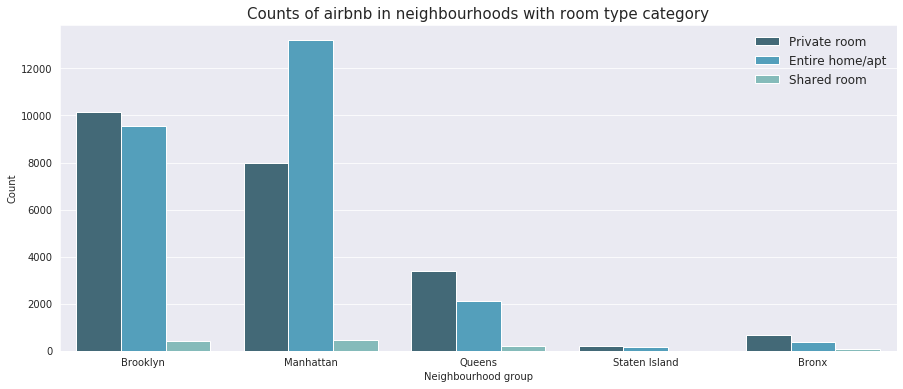

In [42]:
# Visualisation 1 - Neighbourhood groups with counts with category room_type

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='neighbourhood_group', hue='room_type', palette='GnBu_d')
plt.title('Counts of airbnb in neighbourhoods with room type category', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Count")
plt.legend(frameon=False, fontsize=12)

Text(0, 0.5, 'Price')

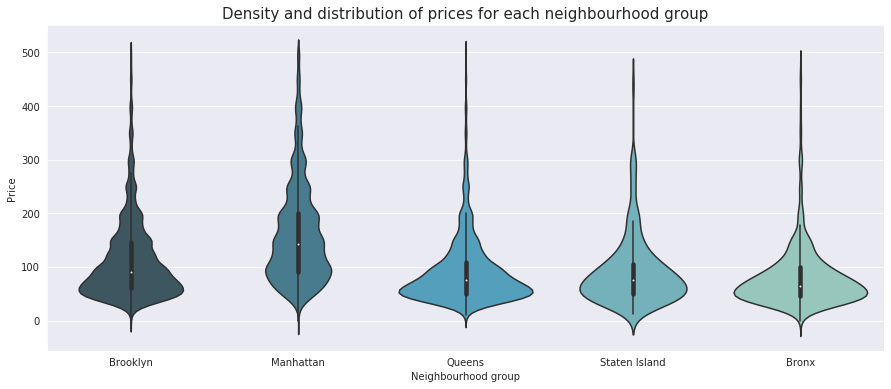

In [43]:
# Visualisation 2 - distribution of prices

plt.figure(figsize=(15,6))
sns.violinplot(data=data[data.price <500], x='neighbourhood_group', y='price', palette='GnBu_d')
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")

<Figure size 1080x432 with 0 Axes>

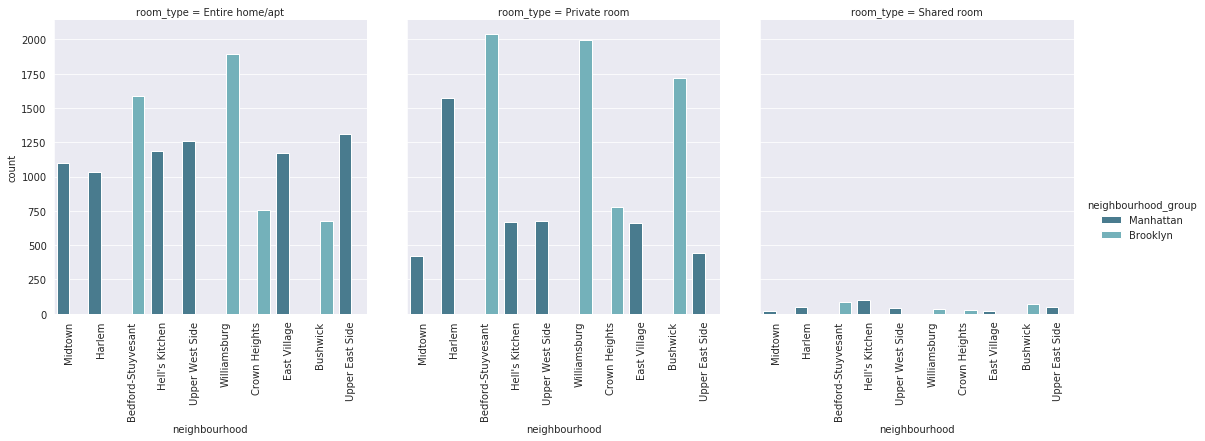

In [44]:
# Visualisation 3 - top neighbourhoods with category of room type

top_nei = data['neighbourhood'].value_counts().reset_index().head(10)
top_nei = top_nei['index'].tolist()

plt.figure(figsize=(15,6))
vis_3 = sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=data.loc[data['neighbourhood'].isin(top_nei)], kind='count', palette='GnBu_d')
vis_3.set_xticklabels(rotation=90)

Text(0, 0.5, 'Count')

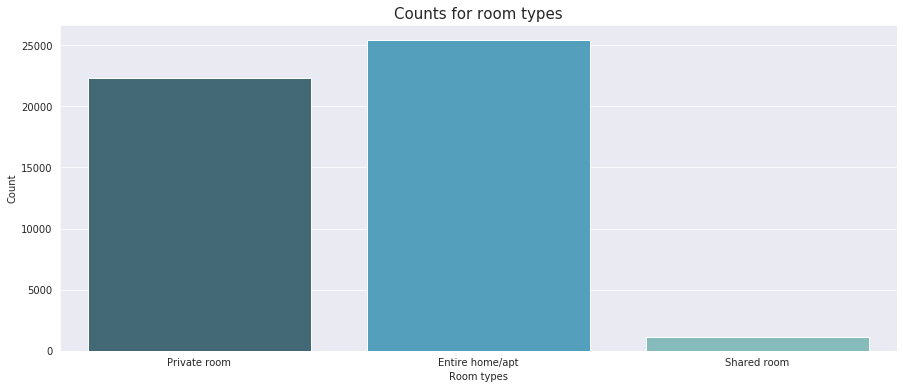

In [45]:
# Visualisation 4 - room types

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='room_type', palette='GnBu_d')
plt.title('Counts for room types', fontsize=15)
plt.xlabel('Room types')
plt.ylabel("Count")

Text(0, 0.5, 'Frequency')

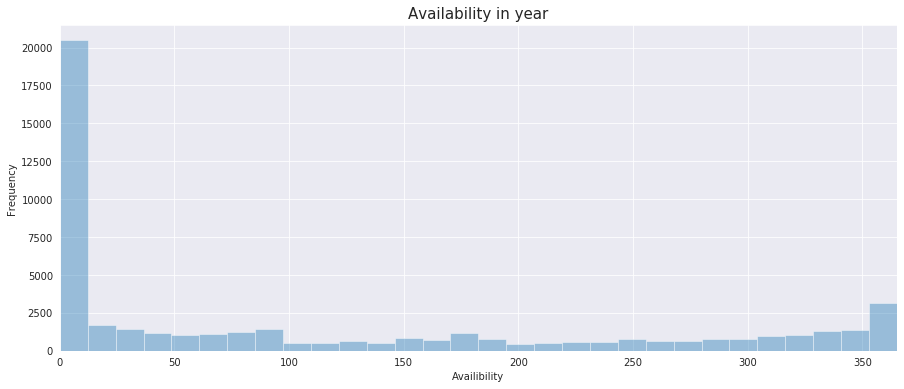

In [46]:
# Visualisation 5 - availability in year

plt.figure(figsize=(15,6))
sns.distplot(data.availability_365, kde=False)
plt.xlim(0,365)
plt.title('Availability in year', fontsize=15)
plt.xlabel('Availibility')
plt.ylabel("Frequency")

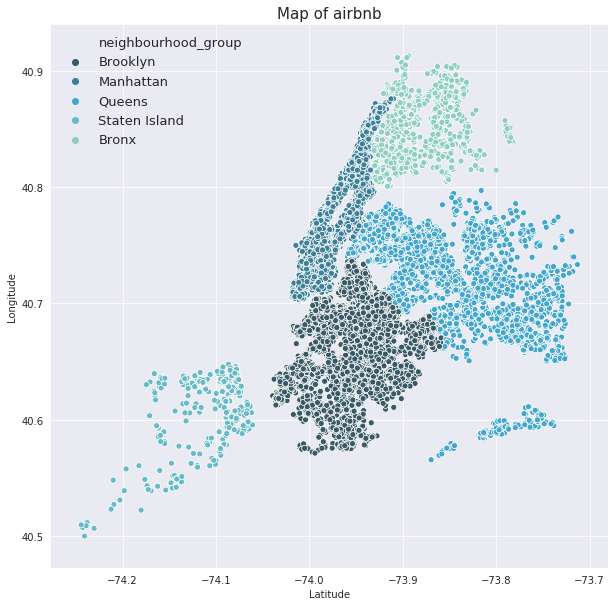

In [47]:
# Visualisation 6 - map of hosts

plt.figure(figsize=(10,10))
a = sns.scatterplot(data=data, x='longitude', y='latitude', hue='neighbourhood_group', palette='GnBu_d')
plt.title('Map of airbnb', fontsize=15)
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.legend(frameon=False, fontsize=13)

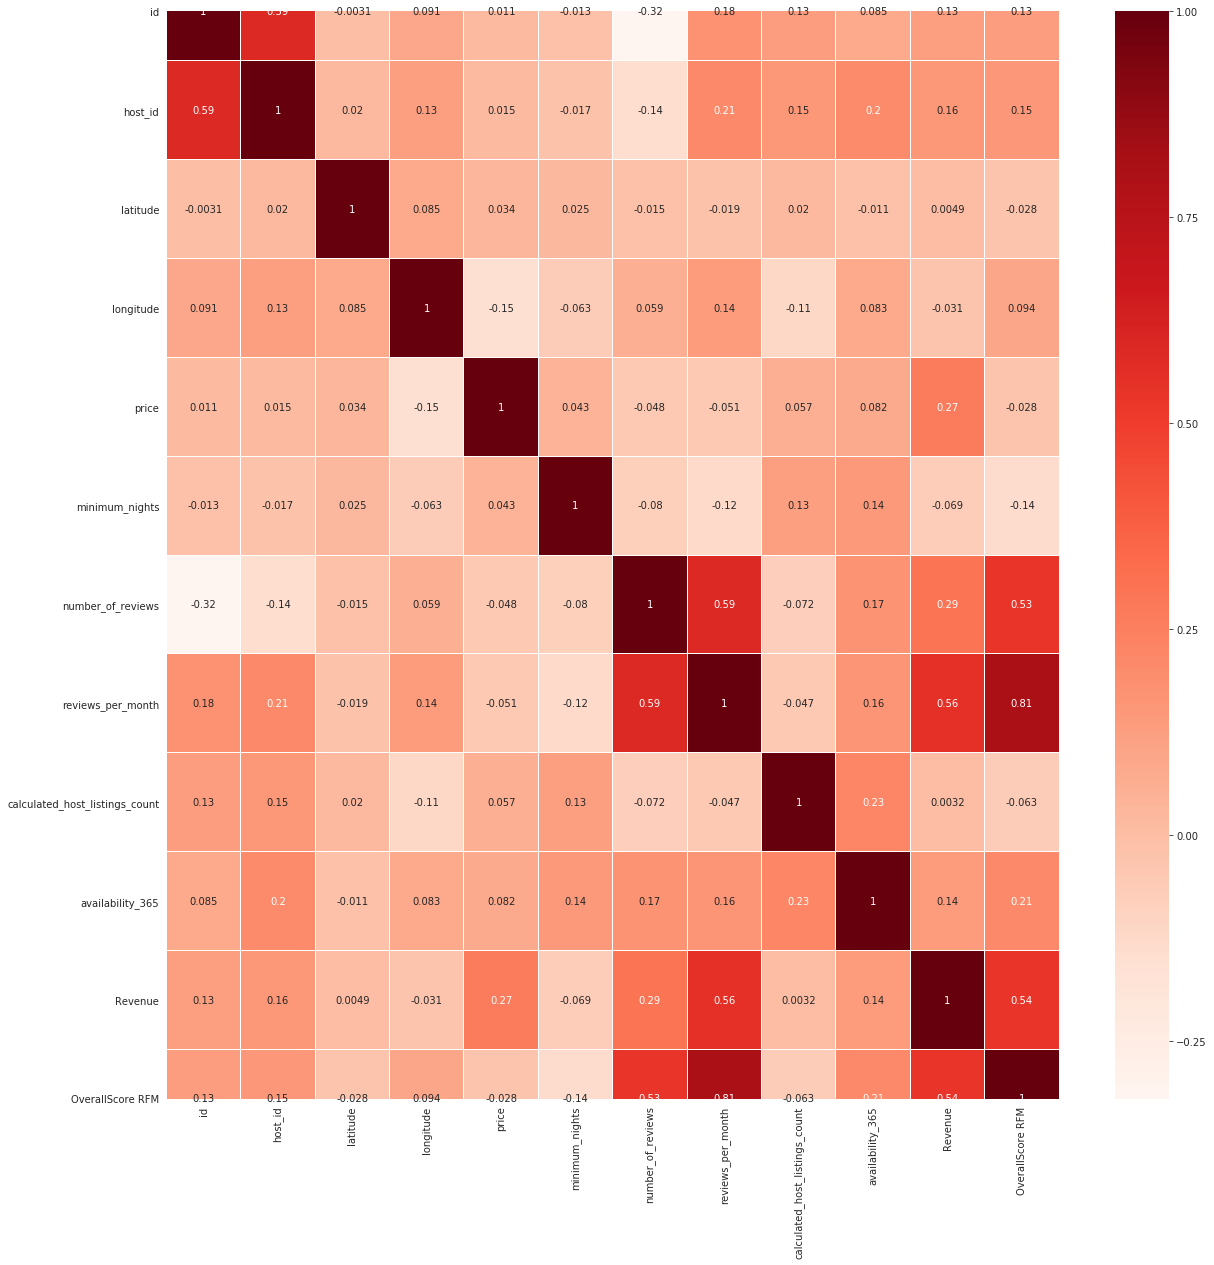

In [48]:
# Visualisation 7 - correlations between values

plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, linewidths=0.1, cmap='Reds')

In [49]:
# Visualisation 8 - prices in neighbourhoods 

data1 = pd.DataFrame(data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean())
data1.reset_index(inplace=True)

bronx = (data1[data1['neighbourhood_group'] =='Bronx']).sort_values(by='price',ascending=False).head(10)
brooklyn = (data1[data1['neighbourhood_group'] =='Brooklyn']).sort_values(by='price',ascending=False).head(10)
manhattan = (data1[data1['neighbourhood_group'] =='Manhattan']).sort_values(by='price',ascending=False).head(10)
queens = (data1[data1['neighbourhood_group'] =='Queens']).sort_values(by='price',ascending=False).head(10)
staten = (data1[data1['neighbourhood_group'] =='Staten Island']).sort_values(by='price',ascending=False).head(10)

neighs = [bronx, brooklyn, manhattan, queens, staten]
titles = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

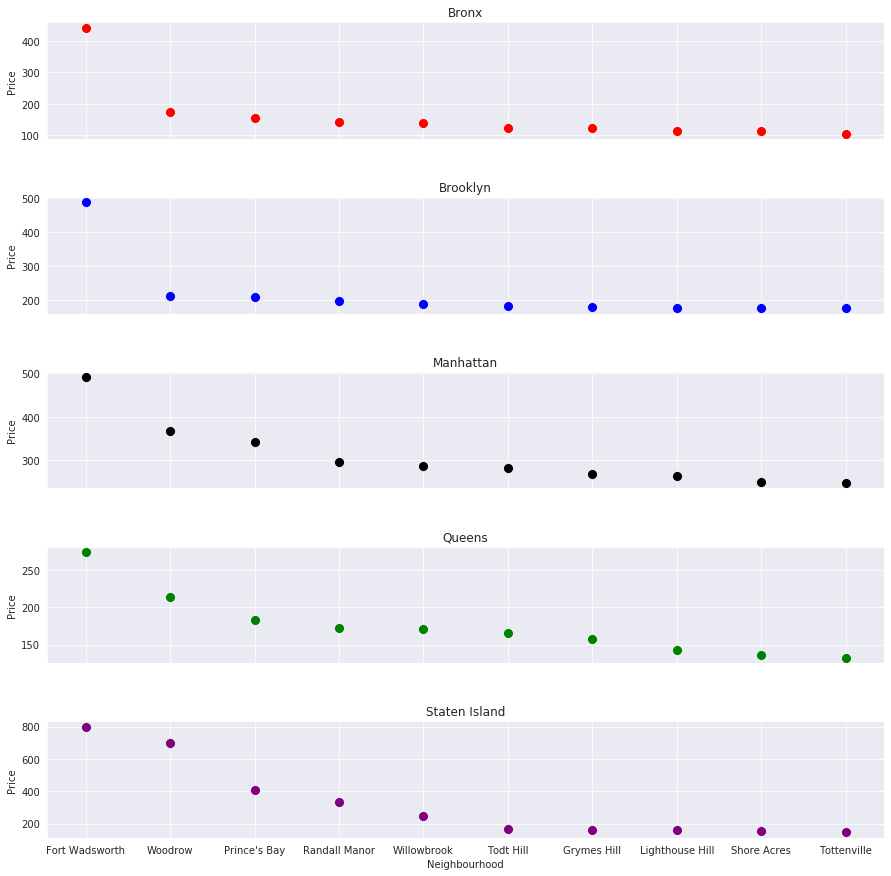

In [50]:
fig, axs = plt.subplots(5, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0})
sns.scatterplot(data=bronx, x='neighbourhood', y='price', ax=axs[0], color='red', s=100)
sns.scatterplot(data=brooklyn, x='neighbourhood', y='price', ax=axs[1], color='blue', s=100)
sns.scatterplot(data=manhattan, x='neighbourhood', y='price', ax=axs[2], color='black', s=100)
sns.scatterplot(data=queens, x='neighbourhood', y='price', ax=axs[3], color='green', s=100)
sns.scatterplot(data=staten, x='neighbourhood', y='price', ax=axs[4], color='purple', s=100)

axs[0].set_title('Bronx')
axs[1].set_title('Brooklyn')
axs[2].set_title('Manhattan')
axs[3].set_title('Queens')
axs[4].set_title('Staten Island')

for ax in axs:
    ax.set(xlabel='Neighbourhood', ylabel='Price')
    ax.label_outer()

5. Predictions

In [51]:
# Preparing dataset for predictions

data_pred = data

In [52]:
data_pred.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews  \
0     Private room    149               1                  9   
1  Entire home/apt    225               1                 45   
2     Private room    150               3                  0   
3  Entire home/apt     89               1                270   
4  Entire home/apt     80              10                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2               0.00                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   

   Revenue  OverallScore RFM  
0    938.7                 3  
1   2565.0                 3  
2      0.0                 0  
3  12388.8                 6  
4    240.0                 3

In [53]:
le = preprocessing.LabelEncoder()

le.fit(data_pred['neighbourhood_group'])
data_pred['neighbourhood_group']=le.transform(data_pred['neighbourhood_group'])

le.fit(data_pred['neighbourhood'])
data_pred['neighbourhood']=le.transform(data_pred['neighbourhood'])

le.fit(data_pred['room_type'])
data_pred['room_type']=le.transform(data_pred['room_type'])
data_pred.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name  neighbourhood_group  neighbourhood  latitude  longitude  \
0         John                    1            108  40.64749  -73.97237   
1     Jennifer                    2            127  40.75362  -73.98377   
2    Elisabeth                    2             94  40.80902  -73.94190   
3  LisaRoxanne                    1             41  40.68514  -73.95976   
4        Laura                    2             61  40.79851  -73.94399   

   room_type  price  minimum_nights  number_of_reviews  reviews_per_month  \
0          1    149               1                  9               0.21   
1          0    225               1                 45               0.38   
2          1    150               3                  0               0.00   
3          0     89               1                270               4.64   
4          0     80              10                  9               0.10   

   calculated_host_listings_count  availability_365  Revenue  OverallScore RFM  
0                               6               365    938.7                 3  
1                               2               355   2565.0                 3  
2                               1               365      0.0                 0  
3                               1               194  12388.8                 6  
4                               1                 0    240.0                 3

In [54]:
data_pred.sort_values('price', ascending=True, inplace=True)

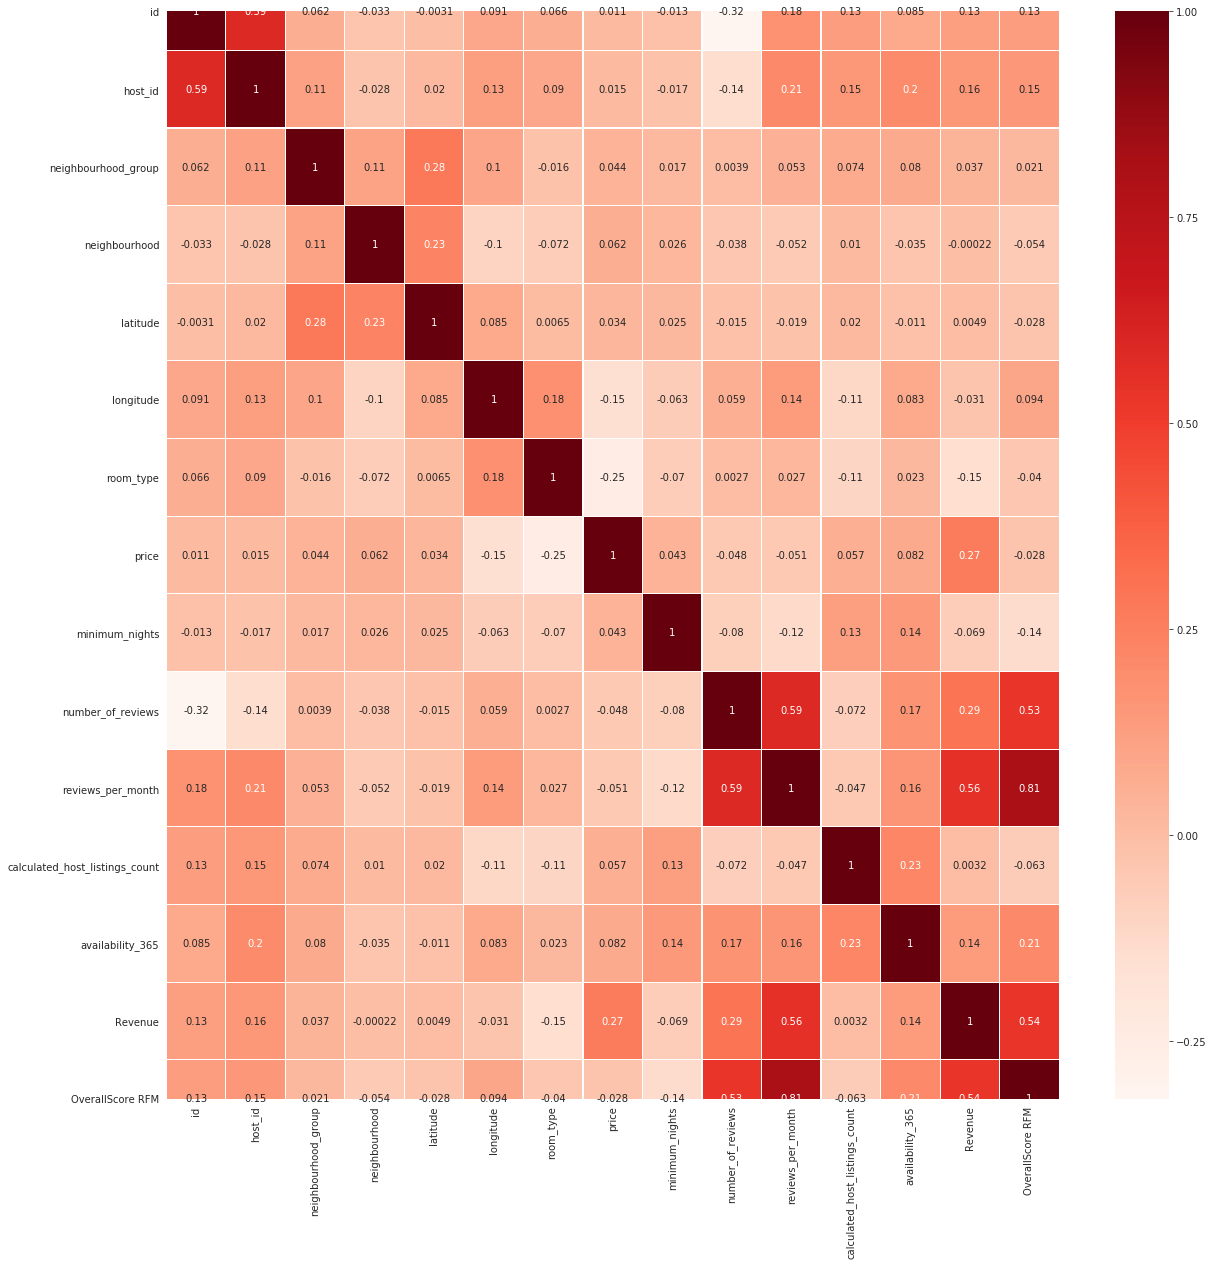

In [55]:
plt.figure(figsize=(20,20))
sns.heatmap(data_pred.corr(), annot=True, linewidths=0.1, cmap='Reds')

In [56]:
data_pred.drop(['longitude', 'host_id', 'host_name', 'name', 'id', 'Revenue'], inplace=True, axis=1)
data_pred.head()

neighbourhood_group  neighbourhood  latitude  room_type  price  \
25796                    1             13  40.68258          1      0   
25634                    1             28  40.69467          1      0   
25433                    0             62  40.83296          1      0   
25753                    1             91  40.72462          1      0   
23161                    1             13  40.69023          1      0   

       minimum_nights  number_of_reviews  reviews_per_month  \
25796               1                 95               4.35   
25634               2                 16               0.71   
25433               2                 55               2.56   
25753               2                 12               0.53   
23161               4                  1               0.05   

       calculated_host_listings_count  availability_365  OverallScore RFM  
25796                               6               222                 5  
25634                               5                 0                 3  
25433                               4               127                 4  
25753                               2                 0                 2  
23161                               4                28                 2

In [57]:
X = data_pred.drop(['price'], inplace=False, axis=1)
y = data_pred['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [58]:
import xgboost as xgb
from sklearn import linear_model

### LINEAR REGRESSION

In [59]:
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions_lm = lm.predict(X_test)

### XGB REGRESSION

In [60]:
xgbr = xgb.XGBRegressor(max_depth=10, random_state=42, n_estimators=500) 
xgbr.fit(X_train, y_train)
predictions_xgbr = xgbr.predict(X_test)

[05:09:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### LASSO REGRESSION

In [61]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
predictions_lasso = lasso.predict(X_test)

### RIDGE REGRESSION

In [62]:
ridge = linear_model.Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
predictions_ridge = ridge.predict(X_test)

### ELASTIC NET REGRESSION

In [71]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(random_state=0)
elastic.fit(X_train, y_train)
predictions_elastic = elastic.predict(X_test)

## Mean Error Calculation Function 

In [72]:
def prediction_error(pred, s):
    mae = metrics.mean_absolute_error(y_test, pred)
    mse = metrics.mean_squared_error(y_test, pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
    r2 = metrics.r2_score(y_test, pred)

    print(s)
    print('Mean Absolute Error: %s' %mae)
    print('Mean Squared Error: %s' %mse)
    print('Root mean squared error: %s' %rmse)
    print('R2 score: %s\n' %r2)

In [73]:
print(prediction_error(predictions_lm, "Linear Regression"), 
      prediction_error(predictions_xgbr, "XGB Regression"), 
      prediction_error(predictions_lasso, "Lasso Regression"),
      prediction_error(predictions_ridge, "Ridge Regression"),
     prediction_error(predictions_elastic, "Elastic Regression"))

Linear Regression
Mean Absolute Error: 74.72846006146914
Mean Squared Error: 33360.00330816506
Root mean squared error: 182.64720996545515
R2 score: 0.09759044050063093

XGB Regression
Mean Absolute Error: 59.595557913530065
Mean Squared Error: 30604.5887003491
Root mean squared error: 174.94167228064646
R2 score: 0.17212617898686589

Lasso Regression
Mean Absolute Error: 74.75517067821777
Mean Squared Error: 33369.257901745485
Root mean squared error: 182.6725428238888
R2 score: 0.09734009778815833

Ridge Regression
Mean Absolute Error: 74.72847931959957
Mean Squared Error: 33360.01487811317
Root mean squared error: 182.64724163839205
R2 score: 0.0975901275260882

Elastic Regression
Mean Absolute Error: 79.01493719920454
Mean Squared Error: 34423.81048219377
Root mean squared error: 185.53654756460725
R2 score: 0.0688137717923113

None None None None None


In [65]:
# Avtual vs predicted values
error = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': predictions_lm.flatten()})
error.head(10)

Actual Values  Predicted Values
0            400        199.568267
1            140        209.741263
2            195        210.903777
3            120         93.325622
4             88         88.830407
5            130        209.461588
6            235        210.125048
7             70        207.811096
8            225        198.681552
9            125         89.608214

Text(0, 0.5, 'XGB Regression Test')

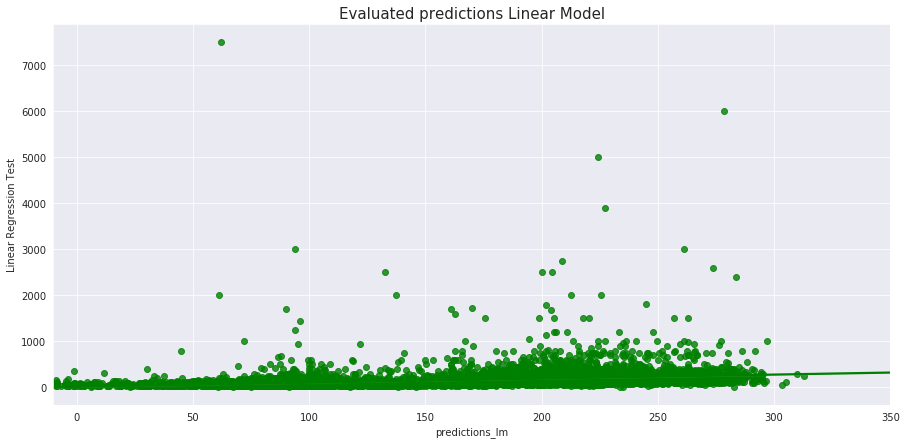

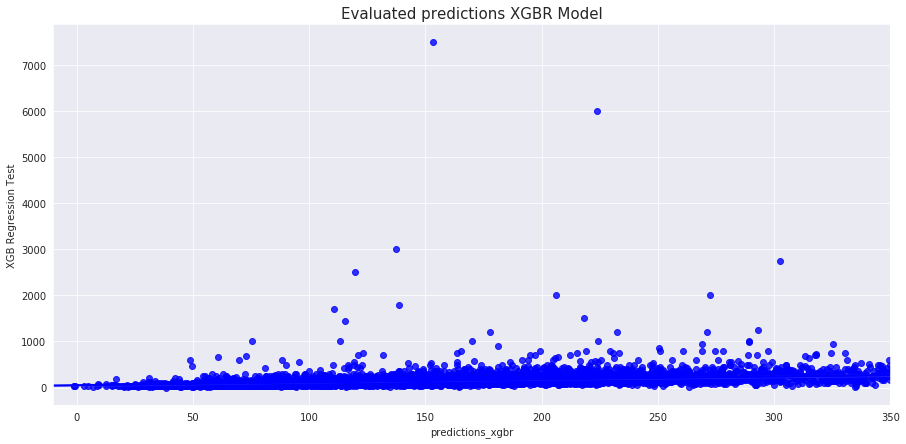

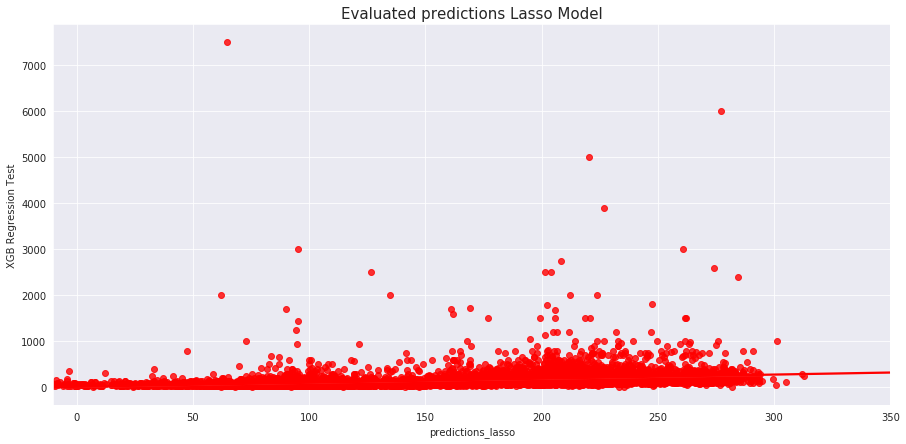

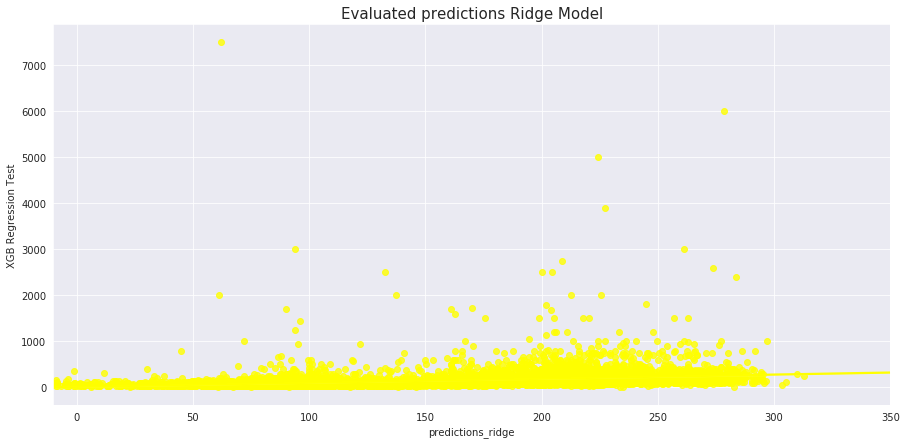

In [66]:
# Evaluated predictions_lm

plt.figure(figsize=(15,7))
plt.xlim(-10,350)
sns.regplot(y=y_test, x=predictions_lm, color='green')
plt.title('Evaluated predictions Linear Model', fontsize=15)
plt.xlabel('predictions_lm')
plt.ylabel('Linear Regression Test')


plt.figure(figsize=(15,7))
plt.xlim(-10,350)
sns.regplot(y=y_test, x=predictions_xgbr, color='blue')
plt.title('Evaluated predictions XGBR Model', fontsize=15)
plt.xlabel('predictions_xgbr')
plt.ylabel('XGB Regression Test')

plt.figure(figsize=(15,7))
plt.xlim(-10,350)
sns.regplot(y=y_test, x=predictions_lasso, color='red')
plt.title('Evaluated predictions Lasso Model', fontsize=15)
plt.xlabel('predictions_lasso')
plt.ylabel('XGB Regression Test')

plt.figure(figsize=(15,7))
plt.xlim(-10,350)
sns.regplot(y=y_test, x=predictions_ridge, color='yellow')
plt.title('Evaluated predictions Ridge Model', fontsize=15)
plt.xlabel('predictions_ridge')
plt.ylabel('XGB Regression Test')